In [ ]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 13.1 MB/s eta 0:00:00


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 12 20:42:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install imblearn

In [ ]:
import tensorflow as tf

# Verifica se a GPU está disponível
gpu_available = tf.config.list_physical_devices('GPU')
print("GPU Available: ", gpu_available)

# Caso esteja disponível, mostra detalhes da GPU
if gpu_available:
    !nvidia-smi


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Jun 12 20:43:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |         

Mounted at /content/drive
[########################################] | 100% Completed | 658.41 ms
[########################################] | 100% Completed | 102.87 ms
[########################################] | 100% Completed | 561.13 ms
[########################################] | 100% Completed | 102.27 ms
[########################################] | 100% Completed | 102.30 ms
[########################################] | 100% Completed | 872.88 ms
[########################################] | 100% Completed | 328.84 ms
[########################################] | 100% Completed | 102.31 ms
[########################################] | 100% Completed | 290.44 ms
[########################################] | 100% Completed | 103.22 ms
[########################################] | 100% Completed | 102.50 ms
[########################################] | 100% Completed | 103.20 ms
[########################################] | 100% Completed | 1.00 s
[########################################

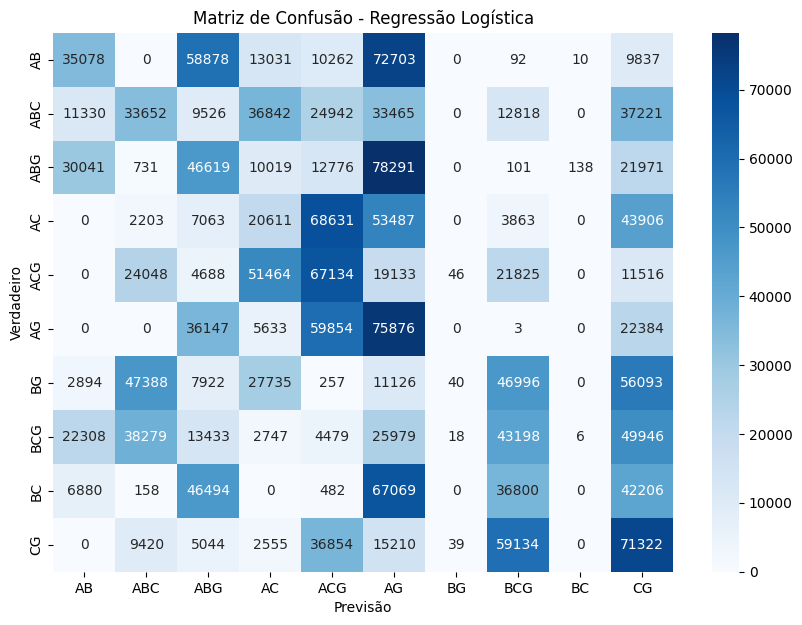

In [ ]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar e pré-processar os dados usando Dask
def process_data(filepath, cols_to_use):
    df = dd.read_csv(filepath, usecols=cols_to_use)
    df = df.drop_duplicates().fillna(df.mean())
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para adicionar rótulos
def add_labels(df, label):
    df['label'] = label
    return df

# Função para processar arquivos em uma pasta
def process_files_in_folder(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if files:
        dfs = [process_data(file, cols_to_use) for file in files]
        df = dd.concat(dfs, axis=0)
        df = df.map_partitions(lambda df_partition: add_labels(df_partition, label))
        return df
    else:
        print(f"No CSV files found in {folder_path}")
        return None

# Função para processar todas as pastas
def process_all_folders(base_path, subfolders):
    folder_dfs = []
    for subfolder in subfolders:
        folder_path = os.path.join(base_path, subfolder)
        df = process_files_in_folder(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                    'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                    'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], subfolder)
        if df is not None:
            folder_dfs.append(df)
    if folder_dfs:
        final_df = dd.concat(folder_dfs, axis=0)
    else:
        final_df = dd.from_pandas(pd.DataFrame(), npartitions=1)
    return final_df

base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

with ProgressBar():
    final_df = process_all_folders(base_path, subfolders).compute()

print("\nDataFrame concluído. Dimensões:", final_df.shape)

# Balanceamento de classes e redução de dimensionalidade
def balance_and_reduce(X, y):
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)
    pca = PCA(n_components=0.95)
    X_res = pca.fit_transform(X_res)
    return X_res, y_res, pca

X = final_df.drop('label', axis=1)
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train, pca = balance_and_reduce(X_train, y_train)

X_test = pca.transform(X_test)

# Inicialização e treinamento do modelo de Regressão Logística
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nModelo: Regressão Logística")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão - Regressão Logística')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()

labels = y.unique() if isinstance(y, pd.Series) else y.unique()
plot_confusion_matrix(conf_matrix, labels=labels)


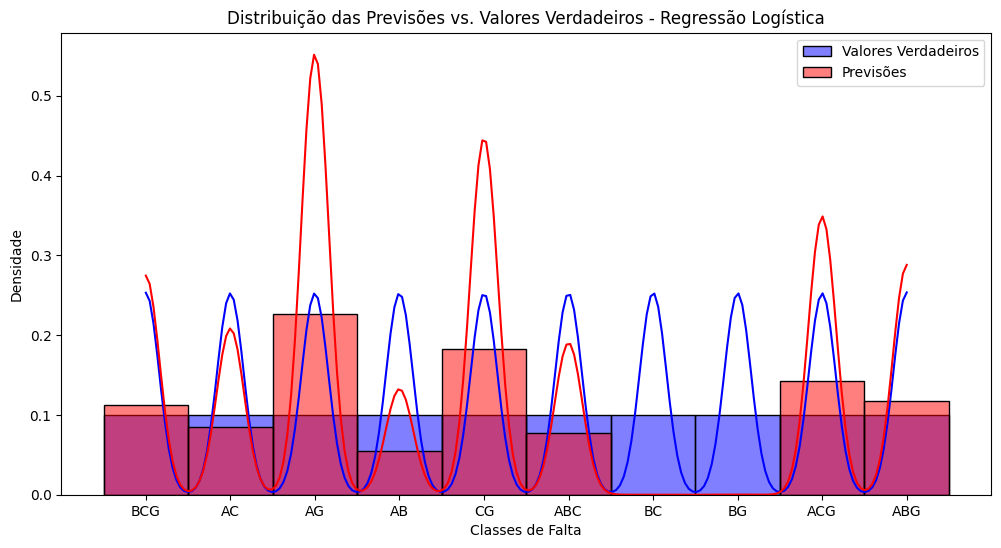

In [ ]:
def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_test, color='blue', label='Valores Verdadeiros', kde=True, stat="density", bins=30)
    sns.histplot(y_pred, color='red', label='Previsões', kde=True, stat="density", bins=30)
    plt.title('Distribuição das Previsões vs. Valores Verdadeiros - Regressão Logística')
    plt.xlabel('Classes de Falta')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

# Chama a função para plotar o gráfico de previsões vs valores verdadeiros
plot_predictions_vs_true(y_test, y_pred)
